In [1]:
%%capture
!pip install gpytorch

In [2]:
import numpy as np
import math
import torch
import gpytorch
import tqdm
import os
from matplotlib import pyplot as plt
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Ursa/")

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
all_clusters = np.loadtxt('all_clusters.txt')
all_labs = np.loadtxt('all_labs.txt')
all_labs_cp = np.loadtxt('all_labs_cleaned.txt')
print(all_clusters.shape, all_labs.shape, all_labs_cp.shape)

(694764, 7) (694764,) (694764,)


In [4]:
train_x = all_clusters[all_labs_cp!=-1.]
train_y = all_labs_cp[all_labs_cp!=-1.]

values, counts = np.unique(train_y, return_counts=True)
print(values, counts)

labels = train_y.copy()
tar_class = 8
labels[train_y==tar_class] = 1. 
labels[train_y!=tar_class] = 0. 

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(labels, dtype=torch.float32)
print(train_x.shape, train_y.shape)
print(train_y.min(), train_y.max())

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [ 75321 123360  69730  54481  38861  39408  46618  55478  91848  27699
  11749  49562   7910]
torch.Size([692025, 7]) torch.Size([692025])
tensor(0.) tensor(1.)


In [5]:
# train_x = torch.linspace(0, 1, 10)
# train_x = torch.rand(10000)
# train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

# train_dataset = TensorDataset(train_x, train_y)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [6]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        inducing_points = train_x[::1000]
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

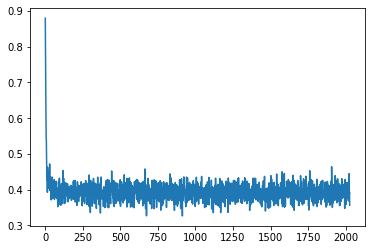

In [7]:
num_epochs = 3
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

losses = []
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        if torch.cuda.is_available():
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = model(x_batch)
        # Calc loss and backprop gradients
        loss = -mll(output, y_batch)
        losses.append(loss)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

plt.plot(losses)

In [8]:
# def test():
#     model.eval()
#     likelihood.eval()

#     correct = 0
#     with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
#         for data, target in train_loader:
#             if torch.cuda.is_available():
#                 data, target = data.cuda(), target.cuda()
#             output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
#             pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
#             correct += pred.eq(target.view_as(pred)).cpu().sum()
#     print('Test set: Accuracy: {}/{} ({}%)'.format(
#         correct, len(test_loader.dataset), 100. * correct / float(len(test_loader.dataset))
#     ))

# for epoch in range(1):
#     with gpytorch.settings.use_toeplitz(False):
#         test()

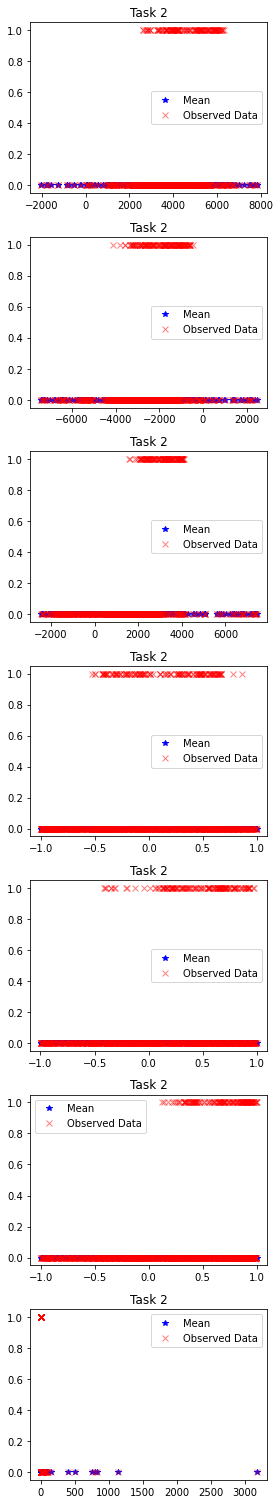

In [9]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(7, 1, figsize=(4, 3 * 7))
    

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        if torch.cuda.is_available():
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

        observed_pred = likelihood(model(x_batch))
        pred_labels = observed_pred.mean.ge(0.5).float()
        mean = pred_labels
        
        for xdim in range(7):
            task = 1
            ax = axs[xdim]
            
            ax.plot(
                x_batch[:, xdim].cpu().detach().numpy(),
                mean.cpu().detach().numpy(),
                '*b',
            )
            ax.plot(
                x_batch[:, xdim].cpu().detach().numpy(),
                y_batch.cpu().detach().numpy(),
                'xr',
                alpha=0.5,
            )
            ax.legend([ 'Mean', 'Observed Data','Confidence'])
            ax.set_title(f'Task {task + 1}')
        break

fig.tight_layout()
None

0.0 1.0
(13896, 7) 1774.0


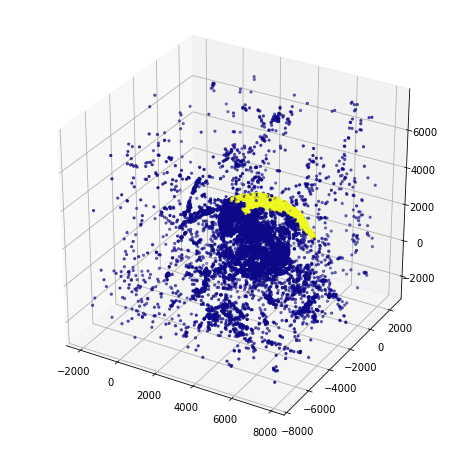

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

labels = all_labs_cp.copy()
labels[all_labs_cp==tar_class] = 1. 
labels[all_labs_cp!=tar_class] = 0.
labels = labels[::50]

plot_data = all_clusters[::50]
plot_y = labels
print(plot_y.min(), plot_y.max())
print(plot_data.shape, plot_y.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")
plt.show()

tensor(0., device='cuda:0') tensor(0., device='cuda:0')
(13896, 7) tensor(0., device='cuda:0')


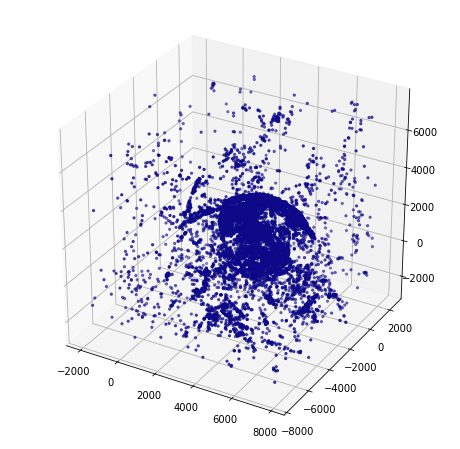

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

eval_data = torch.tensor(all_clusters[::50], dtype=torch.float32)
if torch.cuda.is_available():
    eval_data = eval_data.cuda()
observed_pred = likelihood(model(eval_data))
pred_labels = observed_pred.mean.ge(0.5).float()
mean = pred_labels
plot_y = mean.cpu().detach().numpy()
plot_data = eval_data.cpu().detach().numpy()

print(mean.min(), mean.max())
print(plot_data.shape, mean.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")
plt.show()

In [12]:
test_dist = model(eval_data)
pred_samples = test_dist.sample(torch.Size((1000,)))
print(pred_samples.shape)
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
print(probabilities.shape, mean.shape)
for i in range(0,  mean.shape[0], 1000):
    print(mean[i], probabilities[i])

torch.Size([1000, 13896])
torch.Size([13896]) torch.Size([13896])
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0')


In [13]:
print(torch.ones(10, 5, 12).sum(-2, keepdim=True).mean(0).shape)

torch.Size([1, 12])
